In [1]:
import torch
import torchvision
from torch import nn
from torchvision import datasets
import numpy as np
from collections import OrderedDict
import os
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.logging import TensorBoardLogger
import sys
from scipy import stats 
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import matplotlib.pyplot as pp
import seaborn as sns
%matplotlib inline

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
def mass_bin(vals, boundaries=[0], axis=1):
    return np.apply_along_axis(lambda v: np.histogram(v, bins=boundaries)[0], axis, vals)

In [3]:
def reduce_freqs(n_sections):
    if n_sections == 2:
        def reduce(freqs):
            ratio = freqs[:, 1]/np.sum(freqs, axis=1)
            sns.distplot(ratio, norm_hist=True);
            pp.xlabel('proportion of pre-activations in section 2');
            pp.tight_layout();
                      
    elif n_sections == 3:
        def reduce(freqs):
            ratio_x = freqs[:, 1]/np.sum(freqs, axis=1)
            ratio_y = freqs[:, 2]/np.sum(freqs, axis=1)
            sns.jointplot(x=ratio_x, y=ratio_y, kind='kde').\
            set_axis_labels('proportion of pre-activations in section 2','proportion of pre-activations in section 3');
            pp.tight_layout();
    else:
        def reduce(freqs):
            ratios = np.array([freqs[:, i]/np.sum(freqs, axis=1) for i in range(1,freqs.shape[1])])
            ratios = pd.DataFrame(ratios.T, columns=['section %d'%(i+2) \
                                                     for i in range(freqs.shape[1]-1)])
            sns.pairplot(ratios, diag_kind='kde');
            pp.tight_layout();
    return reduce

## Data

In [4]:
data_dimension = 28*28
dataset_size = 10000
random_data = torch.randn(data_dimension, dataset_size).reshape(-1,1,28,28,)

In [5]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [6]:
#mnist_trainset.data = mnist_trainset.data[:500]

## Architectures

In [7]:
class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output)
    """
    def __init__(self, bias=True, dropout=0.1, activation=nn.ReLU):
        super(LeNet5, self).__init__()

        self.convnet = nn.ModuleDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(4, 4), bias=bias)),
            ('relu1', activation()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(4, 4), bias=bias)),
            ('relu3', activation()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(4, 4), bias=bias)),
            ('relu5', activation())])
        self.fc = nn.ModuleDict([
            ('d6', nn.Dropout(dropout)),
            ('f6', nn.Linear(120, 84, bias=bias)),
            ('relu6', activation()),
            ('d7', nn.Dropout(dropout)),
            ('f7', nn.Linear(84, 10, bias=bias)),
            ('sig7', nn.LogSoftmax(dim=-1))])
        

    def forward(self, img):
        output = img
        for name, layer in self.convnet.items():
            output = layer(output)
        output = output.view(img.size(0), -1)
        for name, layer in self.fc.items():
            output = layer(output)
        return output
    
    def activations(self, img):
        activations = []
        output = img
        for name, layer in self.convnet.items():
            output = layer(output)
            if 'c' in name:
                activations.append(torch.clone(output).reshape(img.shape[0], -1))
        output = output.view(img.size(0), -1)
        for name, layer in self.fc.items():
            output = layer(output)
            if 'f' in name:
                activations.append(torch.clone(output).reshape(img.shape[0], -1))
        return torch.cat(activations, dim=1)

In [8]:
class MLP5(nn.Module):
    def __init__(self, bias=True, dropout=0.1, activation=nn.ReLU):
        super(MLP5, self).__init__()
        
        self.fc = nn.ModuleDict([
            ('d1', nn.Dropout(dropout)),
            ('f1', nn.Linear(28**2, 1000, bias=bias)),
            ('relu1', activation()),
            ('d2', nn.Dropout(dropout)),
            ('f2', nn.Linear(1000, 1000, bias=bias)),
            ('relu2', activation()),
            ('d3', nn.Dropout(dropout)),
            ('f3', nn.Linear(1000, 500, bias=bias)),
            ('relu3', activation()),
            ('d4', nn.Dropout(dropout)),
            ('f4', nn.Linear(500, 250, bias=bias)),
            ('relu4', activation()),
            ('d5', nn.Dropout(dropout)),
            ('f5', nn.Linear(250, 10, bias=bias))])
        
    def forward(self, img):
        output = img
        for name, layer in self.fc.items():
            output = layer(output)
        return output
    
    def activations(self, img):
        activations = []
        output = img
        for name, layer in self.fc.items():
            output = layer(output)
            if 'f' in name:
                activations.append(torch.clone(output).reshape(img.shape[0], -1))
        return torch.cat(activations, dim=1)

## Custom activation function

In [9]:
def bucketize(tensor, bucket_boundaries):
    # Naive implentation of analogue of numpy.digitize.
    # See https://github.com/pytorch/pytorch/issues/7284 for in-progress engineered solution in Torch.
    result = torch.zeros_like(tensor, dtype=torch.long, device=tensor.device)
    for boundary in bucket_boundaries:
        result += (tensor > boundary).long()
    return result

def piecewise_linear(x, boundaries, gradients, intercepts):
    buckets = bucketize(x, boundaries)
    return (x*gradients[buckets] + intercepts[buckets]).float()

class PiecewiseLinear(nn.Module):
    def __init__(self, boundaries, gradients, intercept, *args, **kwargs):
        super(PiecewiseLinear, self).__init__(*args, **kwargs)
        intercepts = np.zeros(gradients.shape[0])
        zero_bucket = np.digitize(0, boundaries)
        intercepts[zero_bucket ] = intercept
        for boundary_idx in np.argwhere(np.sort(boundaries) > 0):
            intercepts[boundary_idx+1] = gradients[boundary_idx]*boundaries[boundary_idx] \
                                                + intercepts[boundary_idx] \
                                                - gradients[boundary_idx+1]*boundaries[boundary_idx]
        for boundary_idx in np.argwhere(np.sort(boundaries) < 0)[::-1]:
            intercepts[boundary_idx] = gradients[boundary_idx+1]*boundaries[boundary_idx] \
                                                + intercepts[boundary_idx+1]\
                                                - gradients[boundary_idx]*boundaries[boundary_idx]
        self.intercepts = torch.nn.Parameter(torch.tensor(intercepts), requires_grad=False)
        self.boundaries = torch.nn.Parameter(torch.tensor(boundaries), requires_grad=False)
        self.gradients = torch.nn.Parameter(torch.tensor(gradients), requires_grad=False)
        
        
    def forward(self, x):
        return piecewise_linear(x, self.boundaries, self.gradients, self.intercepts)

def make_piecewiselinear(boundaries, gradients, intercept,  *args, **kwargs):
    def make_module():
        return PiecewiseLinear(np.array(boundaries), np.array(gradients), intercept,  *args, **kwargs)
    return make_module
        

## Parameters

In [95]:
min_epochs, max_epochs = 5, 10
batch_size = 32
activation = '5piece'

if activation == 'relu':
    ACTIVATION = nn.ReLU
    ACTIVATION_NAME = 'relu'
    BOUNDARIES = [-1e10, 0, 1e10]
elif activation == 'hardtanh':
    ACTIVATION = nn.Hardtanh
    ACTIVATION_NAME = 'hardtanh'
    BOUNDARIES = [-1e10, -1, 1, 1e10]
elif activation == '5piece':
    ACTIVATION_NAME = '5piece'
    BOUNDARIES = [-1e10, -2, -1, 1, 2, 1e10]
    GRADIENTS = [0.01, 0.1, 1, 0.3, 0.03]
    INTERCEPT = 0.
    ACTIVATION = make_piecewiselinear(BOUNDARIES[1:-1], GRADIENTS, INTERCEPT)

freq_reducer = reduce_freqs(len(BOUNDARIES) - 1)

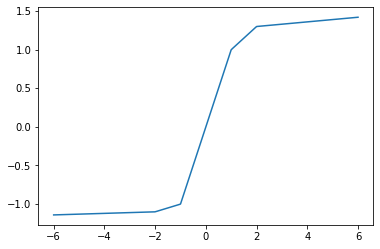

In [96]:
act = ACTIVATION()
x = torch.linspace(-6,6,500)
y = act(x)
sns.lineplot(x.detach().numpy(), y.detach().numpy());

## Experiment 1: aggregate neurons

In [97]:
def make_exp_plots(module, data, data_name, fig_name, module_name):
    # Get activations and plot
    model = module(activation=ACTIVATION)
    model = model.eval().to(DEVICE)
    act = model.activations(data.to(DEVICE)).detach().cpu().numpy()
    freqs = mass_bin(act, boundaries=BOUNDARIES, axis=1)

    freq_reducer(freqs)
    #pp.xlabel('proportion of positive pre-activations');
    #pp.title('%s data,pre-activations aggregated, %s '%(data_name, module_name));
    pp.tight_layout();
    pp.savefig(fig_name);
    
def make_exp_plots_trained(model, data, data_name, fig_name, module_name):
    # Get activations and plot
    model = model.eval().to(DEVICE)
    
    act = model.activations(data.to(DEVICE)).detach().cpu().numpy()
    freqs = mass_bin(act, boundaries=BOUNDARIES, axis=1)

    freq_reducer(freqs)
    pp.tight_layout();
    pp.savefig(fig_name);

#### Random LeNet5

##### Random data

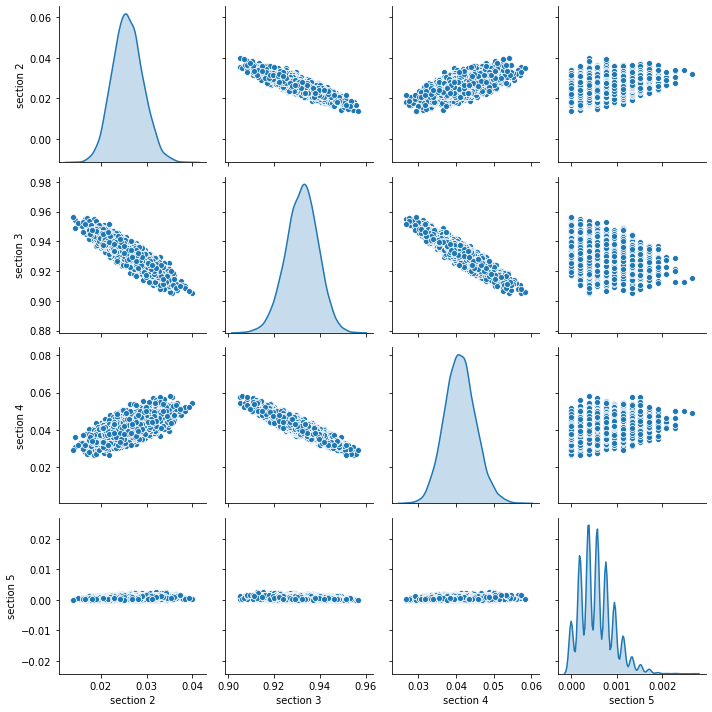

In [98]:
data = random_data
data_name = 'i.i.d. standard normal'
fig_name = 'iid_normal_data_lenet5_aggregated_neurons_ratiohist_%s.pdf'%ACTIVATION_NAME
module = LeNet5
module_name = 'LeNet5'

make_exp_plots(module, data.reshape(-1,1,28,28), data_name, fig_name, module_name)

##### MNIST data

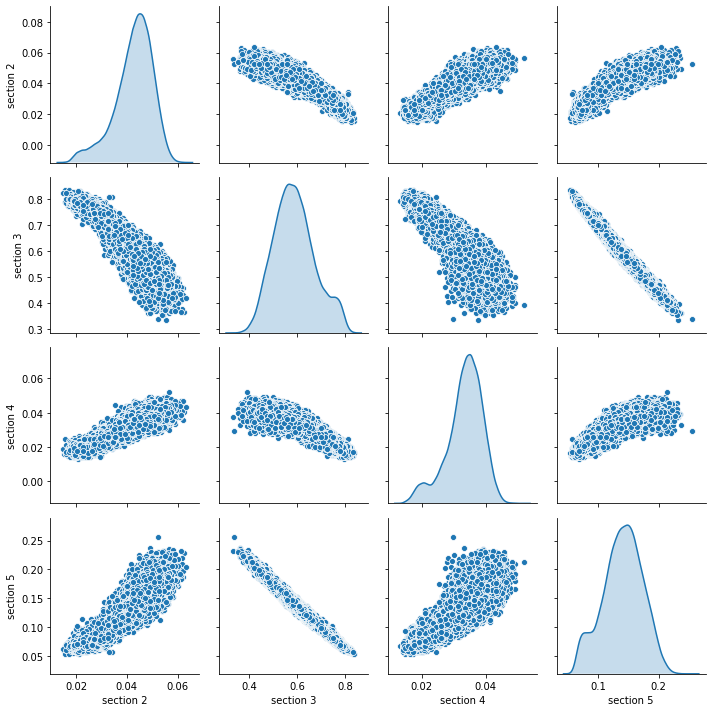

In [99]:
data = mnist_trainset.data.float()
data_name = 'MNIST'
fig_name = 'MNIST_data_lenet5_aggregated_neurons_ratiohist_%s.pdf'%ACTIVATION_NAME
module = LeNet5
module_name = 'LeNet5'

make_exp_plots(module, data.reshape(-1,1,28,28), data_name, fig_name, module_name)

#### Random 5 layer MLP

##### Random normal data

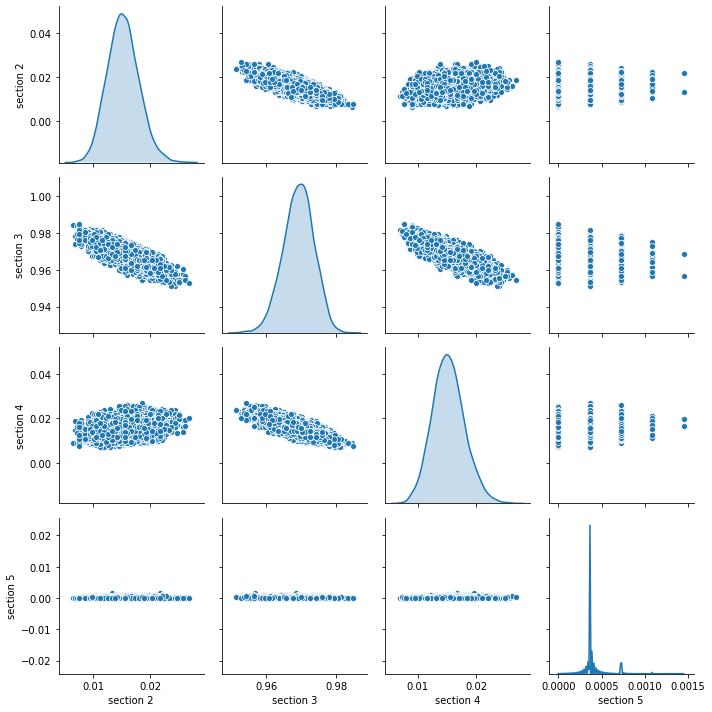

In [100]:
data = random_data
data_name = 'i.i.d. standard normal'
fig_name = 'iid_normal_data_MLP5_aggregated_neurons_ratiohist_%s.pdf'%ACTIVATION_NAME
module = MLP5
module_name = 'MLP5'

make_exp_plots(module, data.reshape(-1,28*28), data_name, fig_name, module_name)

##### MNIST data

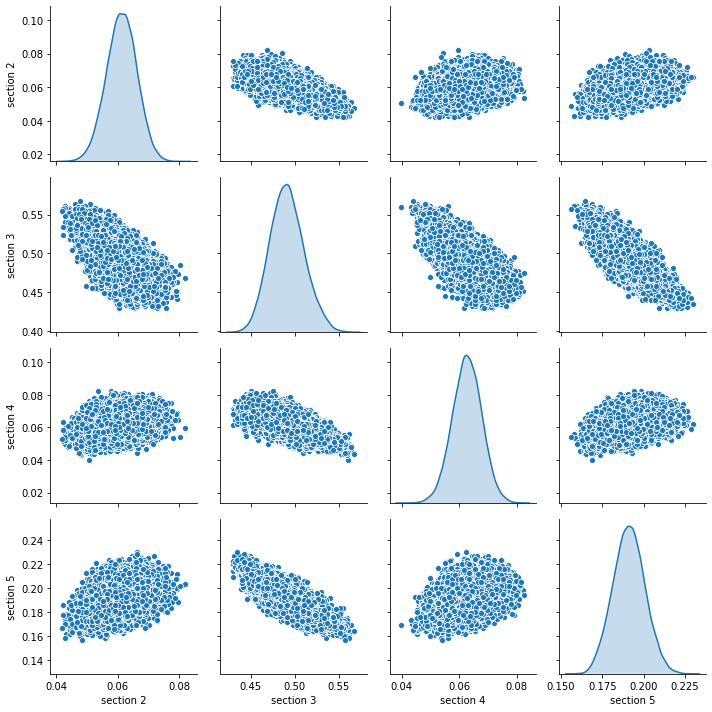

In [101]:
data = mnist_trainset.data.float()
data_name = 'MNIST'
fig_name = 'MNIST_data_MLP5_aggregated_neurons_ratiohist_%s.pdf'%ACTIVATION_NAME
module = MLP5
module_name = 'MLP5'

make_exp_plots(module, data.reshape(-1,28*28), data_name, fig_name, module_name)

#### Trained Lenet5

In [102]:
class LeNet5System(pl.LightningModule):

    def __init__(self):
        super(LeNet5System, self).__init__()
        # not the best model...
        self.model =  LeNet5(activation=ACTIVATION)
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def activations(self, x):
        return self.model.activations(x)
    
    def training_step(self, batch, batch_idx):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        # OPTIONAL
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': self.loss(y_hat, y),
                'val_acc': (y==torch.argmax(y_hat, dim=1)).float().sum()/x.shape[0]}

    def validation_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        tensorboard_logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

        
    def test_step(self, batch, batch_idx):
        # OPTIONAL
        x, y = batch
        y_hat = self.forward(x)
        return {'test_loss': self.loss(y_hat, y)}

    def test_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        return {'avg_test_loss': avg_loss}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST(os.getcwd(), train=True, download=True, transform=torchvision.transforms.ToTensor()), batch_size=batch_size)

    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST(os.getcwd(), train=False, download=True, transform=torchvision.transforms.ToTensor()), batch_size=batch_size)

    @pl.data_loader
    def test_dataloader(self):
        # OPTIONAL
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST(os.getcwd(), train=False, download=True, transform=torchvision.transforms.ToTensor()), batch_size=batch_size)
    

In [103]:
data = mnist_trainset.data.float()
data_name = 'MNIST'
fig_name = 'MNIST_data_lenet5_trained_aggregated_neurons_ratiohist_%s.pdf'%ACTIVATION_NAME
module_name = 'LeNet5'
trained_lenet_model = LeNet5System()
trainer = Trainer(max_epochs=max_epochs, min_epochs=min_epochs, 
                  logger=TensorBoardLogger(save_dir='logs', name='lenet5_%s'%ACTIVATION_NAME))

In [104]:
trainer.fit(trained_lenet_model)

INFO:root:
                   Name              Type Params
0                 model            LeNet5   43 K
1         model.convnet        ModuleDict   32 K
2      model.convnet.c1            Conv2d  102  
3   model.convnet.relu1   PiecewiseLinear   14  
4      model.convnet.s2         MaxPool2d    0  
5      model.convnet.c3            Conv2d    1 K
6   model.convnet.relu3   PiecewiseLinear   14  
7      model.convnet.s4         MaxPool2d    0  
8      model.convnet.c5            Conv2d   30 K
9   model.convnet.relu5   PiecewiseLinear   14  
10             model.fc        ModuleDict   11 K
11          model.fc.d6           Dropout    0  
12          model.fc.f6            Linear   10 K
13       model.fc.relu6   PiecewiseLinear   14  
14          model.fc.d7           Dropout    0  
15          model.fc.f7            Linear  850  
16        model.fc.sig7        LogSoftmax    0  
17                 loss  CrossEntropyLoss    0  
                                                          

Epoch 1:   0%|          | 4/2188 [00:00<00:56, 38.43batch/s, batch_idx=3, loss=2.287, v_num=2]

Epoch 2:   0%|          | 9/2188 [00:00<00:22, 95.32batch/s, batch_idx=8, loss=0.081, v_num=2]      

/Users/p41766/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/training_io.py:342: UserWarning: Did not find hyperparameters at model.hparams. Saving checkpoint without hyperparameters
  "Did not find hyperparameters at model.hparams. Saving checkpoint without"


Epoch 4:  94%|█████████▍| 2062/2188 [00:41<00:01, 105.64batch/s, batch_idx=1874, loss=0.037, v_num=2]


Epoch 7:  90%|████████▉ | 1960/2188 [00:40<00:02, 97.52batch/s, batch_idx=1874, loss=0.025, v_num=2]


Epoch 9:  99%|█████████▉| 2163/2188 [00:41<00:00, 105.61batch/s, batch_idx=1874, loss=0.021, v_num=2]


Epoch 10: 100%|██████████| 2188/2188 [00:41<00:00, 105.87batch/s, batch_idx=1874, loss=0.017, v_num=2]
                                                                 

INFO:root:Epoch 00010: early stopping


Epoch 10: 100%|██████████| 2188/2188 [00:42<00:00, 52.09batch/s, batch_idx=1874, loss=0.017, v_num=2] 


1

Model achieves 98% test accuracy.

##### Eval on MNIST data

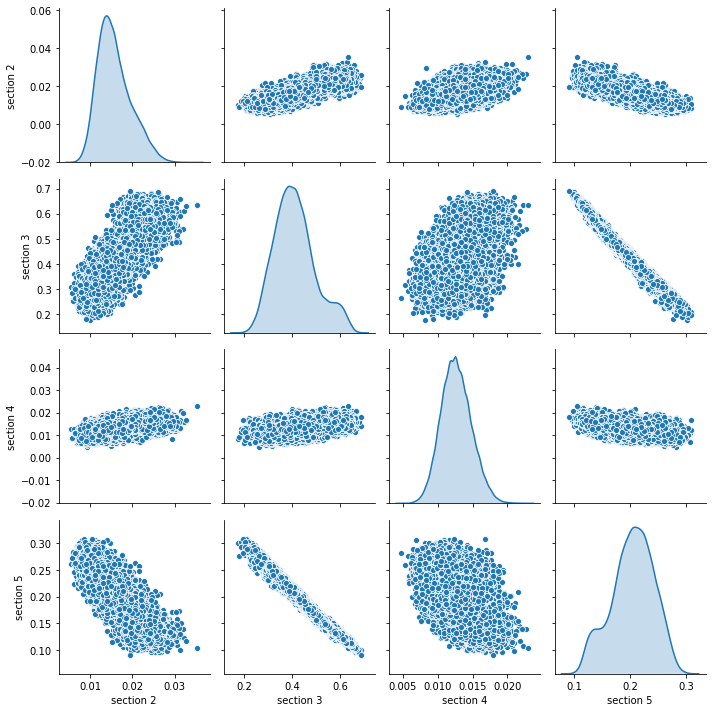

In [105]:
trained_lenet_model = trained_lenet_model.eval()
make_exp_plots_trained(trained_lenet_model, data.reshape(-1,1,28,28), data_name, fig_name, module_name)

##### Eval on random data

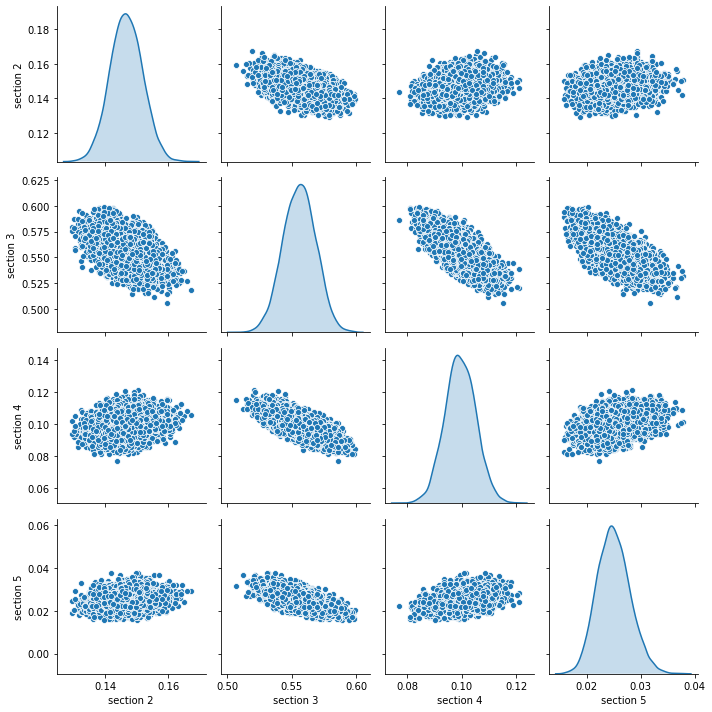

In [106]:
data = random_data
data_name = 'MNIST'
fig_name = 'iid_normal_data_lenet5_MNIST_trained_aggregated_neurons_ratiohist_%s.pdf'%ACTIVATION_NAME
trained_lenet_model = trained_lenet_model.eval()
make_exp_plots_trained(trained_lenet_model, data.reshape(-1,1,28,28), data_name, fig_name, module_name)

#### Trained MLP5

In [107]:
class ReshapeFlat:
    def __call__(self, sample):
        return sample.reshape(-1)

class MLP5System(pl.LightningModule):

    def __init__(self):
        super(MLP5System, self).__init__()
        # not the best model...
        self.model =  MLP5(activation=ACTIVATION)
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def activations(self, x):
        return self.model.activations(x)
    
    def training_step(self, batch, batch_idx):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        # OPTIONAL
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': self.loss(y_hat, y),
                'val_acc': (y==torch.argmax(y_hat, dim=1)).float().sum()/x.shape[0]}

    def validation_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        tensorboard_logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

        
    def test_step(self, batch, batch_idx):
        # OPTIONAL
        x, y = batch
        y_hat = self.forward(x)
        return {'test_loss': self.loss(y_hat, y)}

    def test_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        return {'avg_test_loss': avg_loss}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST(os.getcwd(), train=True, download=True, \
                        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                  ReshapeFlat()])),\
                        batch_size=batch_size)

    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST(os.getcwd(), train=False, download=True, \
                        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                  ReshapeFlat()])),\
                        batch_size=batch_size)
    @pl.data_loader
    def test_dataloader(self):
        # OPTIONAL
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST(os.getcwd(), train=False, download=True, \
                        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                  ReshapeFlat()])),\
                        batch_size=batch_size)
                                           

In [108]:
data = mnist_trainset.data.float()
data_name = 'MNIST'
fig_name = 'MNIST_data_MLP5_trained_aggregated_neurons_ratiohist_%s.pdf'%ACTIVATION_NAME
module_name = 'MLP5'
trained_mlp_model = MLP5System()
trainer = Trainer(max_epochs=max_epochs, min_epochs=min_epochs, 
                  logger=TensorBoardLogger(save_dir='logs', name='mlp5_%s'%ACTIVATION_NAME))

In [109]:
trainer.fit(trained_mlp_model)

INFO:root:
              Name              Type Params
0            model              MLP5    2 M
1         model.fc        ModuleDict    2 M
2      model.fc.d1           Dropout    0  
3      model.fc.f1            Linear  785 K
4   model.fc.relu1   PiecewiseLinear   14  
5      model.fc.d2           Dropout    0  
6      model.fc.f2            Linear    1 M
7   model.fc.relu2   PiecewiseLinear   14  
8      model.fc.d3           Dropout    0  
9      model.fc.f3            Linear  500 K
10  model.fc.relu3   PiecewiseLinear   14  
11     model.fc.d4           Dropout    0  
12     model.fc.f4            Linear  125 K
13  model.fc.relu4   PiecewiseLinear   14  
14     model.fc.d5           Dropout    0  
15     model.fc.f5            Linear    2 K
16            loss  CrossEntropyLoss    0  
                                                                 

Epoch 1:   0%|          | 3/2188 [00:00<01:28, 24.57batch/s, batch_idx=2, loss=2.166, v_num=2]

Epoch 2:   0%|          | 5/2188 [00:00<00:16, 134.94batch/s, batch_idx=4, loss=0.203, v_num=2]      

/Users/p41766/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/training_io.py:342: UserWarning: Did not find hyperparameters at model.hparams. Saving checkpoint without hyperparameters
  "Did not find hyperparameters at model.hparams. Saving checkpoint without"


Epoch 5:  89%|████████▉ | 1950/2188 [01:04<00:02, 91.38batch/s, batch_idx=1874, loss=0.091, v_num=2]


Epoch 8:  97%|█████████▋| 2114/2188 [01:05<00:00, 137.67batch/s, batch_idx=1874, loss=0.082, v_num=2]


Epoch 9: 100%|██████████| 2188/2188 [01:06<00:00, 144.31batch/s, batch_idx=1874, loss=0.080, v_num=2]
                                                                 

INFO:root:Epoch 00009: early stopping


Epoch 9: 100%|██████████| 2188/2188 [01:06<00:00, 33.11batch/s, batch_idx=1874, loss=0.080, v_num=2] 


1

Model achieves 97% accuracy.

##### Eval on MNIST

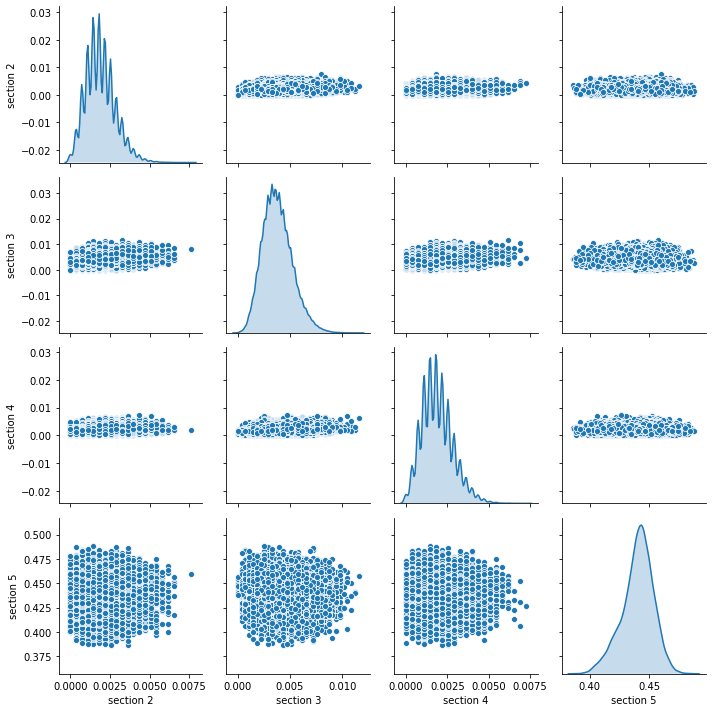

In [110]:
trained_mlp_model = trained_mlp_model.eval()
make_exp_plots_trained(trained_mlp_model, data.reshape(-1,28**2), data_name, fig_name, module_name)

##### Eval on random data

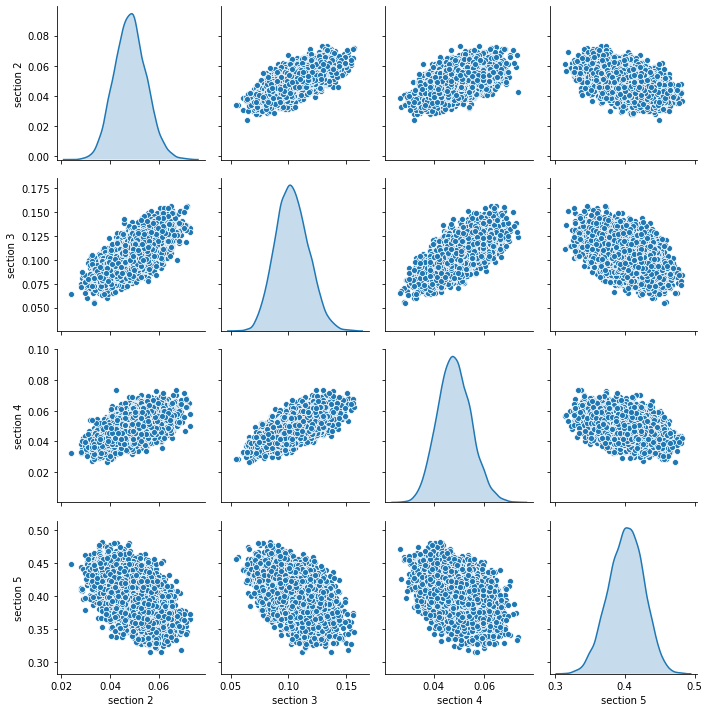

In [111]:
data = random_data
data_name = 'MNIST'
fig_name = 'iid_normal_data_MLP5__MNIST_trained_aggregated_neurons_ratiohist_%s.pdf'%ACTIVATION_NAME
trained_mlp_model = trained_mlp_model.eval()
make_exp_plots_trained(trained_mlp_model, data.reshape(-1,28**2), data_name, fig_name, module_name)

# Experiment 2: single neurons

In [112]:
def make_exp_plots(module, data, data_name, fig_name, module_name):
    # Get activations and plot
    model = module(activation=ACTIVATION)
    model = model.eval().to(DEVICE)
    act = model.activations(data.to(DEVICE)).detach().cpu().numpy()
    freqs = mass_bin(act, boundaries=BOUNDARIES, axis=0).T

    freq_reducer(freqs)
    #pp.xlabel('proportion of positive pre-activations');
    #pp.title('%s data,pre-activations aggregated, %s '%(data_name, module_name));
    pp.tight_layout();
    pp.savefig(fig_name);
    
def make_exp_plots_trained(model, data, data_name, fig_name, module_name):
    # Get activations and plot
    model = model.eval().to(DEVICE)
    
    act = model.activations(data.to(DEVICE)).detach().cpu().numpy()
    freqs = mass_bin(act, boundaries=BOUNDARIES, axis=0).T

    freq_reducer(freqs)
    pp.tight_layout();
    pp.savefig(fig_name);

#### Random LeNet5

##### Random data

<Figure size 504x360 with 0 Axes>

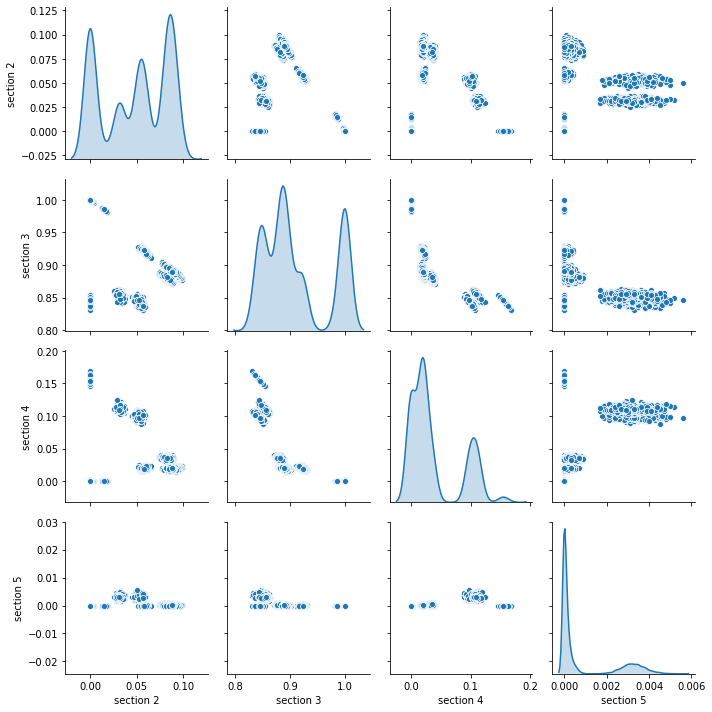

In [113]:
data = random_data
data_name = 'i.i.d. standard normal'
fig_name = 'iid_normal_data_lenet5_aggregated_data_ratiohist_%s.pdf'%ACTIVATION_NAME
module = LeNet5
module_name = 'LeNet5'
pp.figure(figsize=(7,5));
make_exp_plots(module, data.reshape(-1,1,28,28), data_name, fig_name, module_name);

##### MNIST data

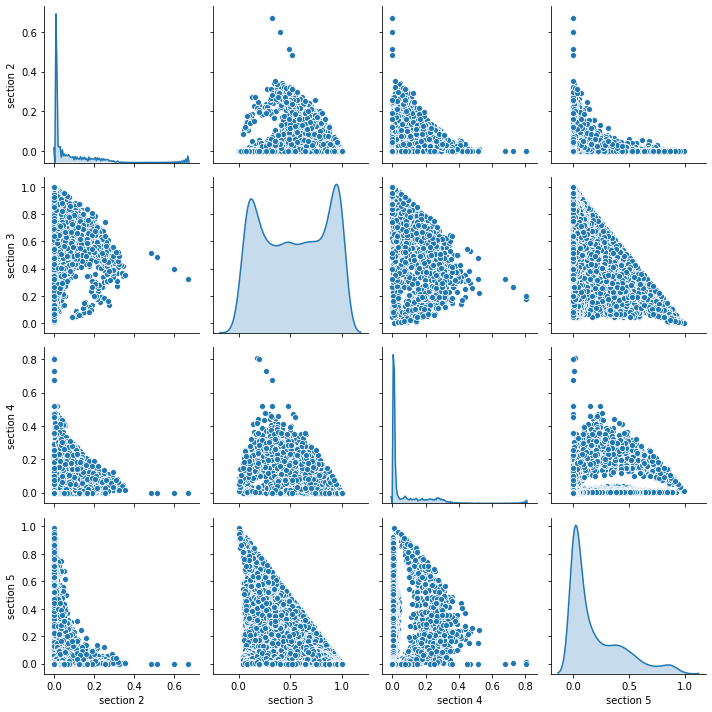

In [114]:
data = mnist_trainset.data.float()
data_name = 'MNIST'
fig_name = 'MNIST_data_lenet5_aggregated_data_ratiohist_%s.pdf'%ACTIVATION_NAME
module = LeNet5
module_name = 'LeNet5'
make_exp_plots(module, data.reshape(-1,1,28,28), data_name, fig_name, module_name);

#### Random 5 layer MLP

##### Random normal data

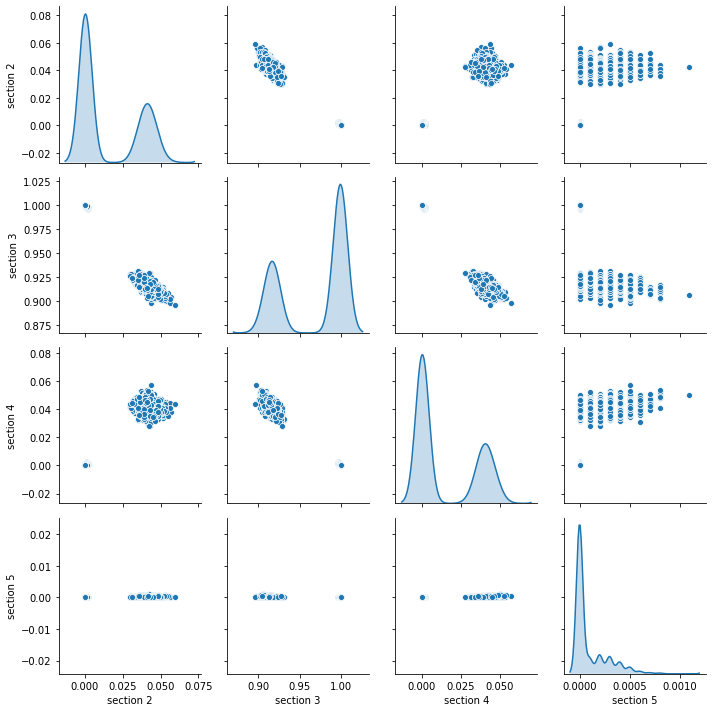

In [115]:
data = random_data
data_name = 'i.i.d. standard normal'
fig_name = 'iid_normal_data_MLP5_aggregated_data_ratiohist_%s.pdf'%ACTIVATION_NAME
module = MLP5
module_name = 'MLP5'

make_exp_plots(module, data.reshape(-1,28*28), data_name, fig_name, module_name)

##### MNIST data

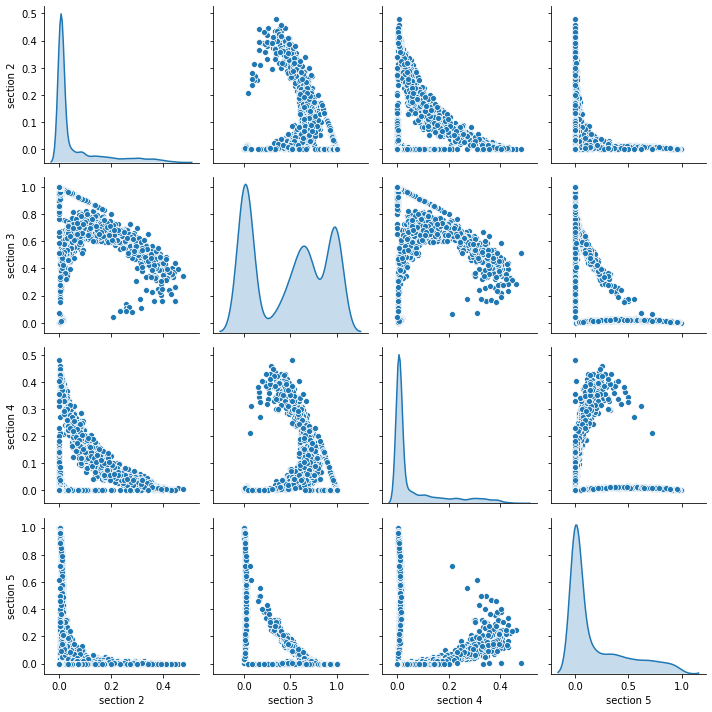

In [116]:
data = mnist_trainset.data.float()
data_name = 'MNIST'
fig_name = 'MNIST_data_MLP5_aggregated_data_ratiohist_%s.pdf'%ACTIVATION_NAME
module = MLP5
module_name = 'MLP5'

make_exp_plots(module, data.reshape(-1,28*28), data_name, fig_name, module_name)

#### Trained Lenet5

In [117]:
data = mnist_trainset.data.float()
data_name = 'MNIST'
fig_name = 'MNIST_data_lenet5_trained_aggregated_data_ratiohist_%s.pdf'%ACTIVATION_NAME
module_name = 'LeNet5'


Model achieves 98% test accuracy.

##### Eval on MNIST data

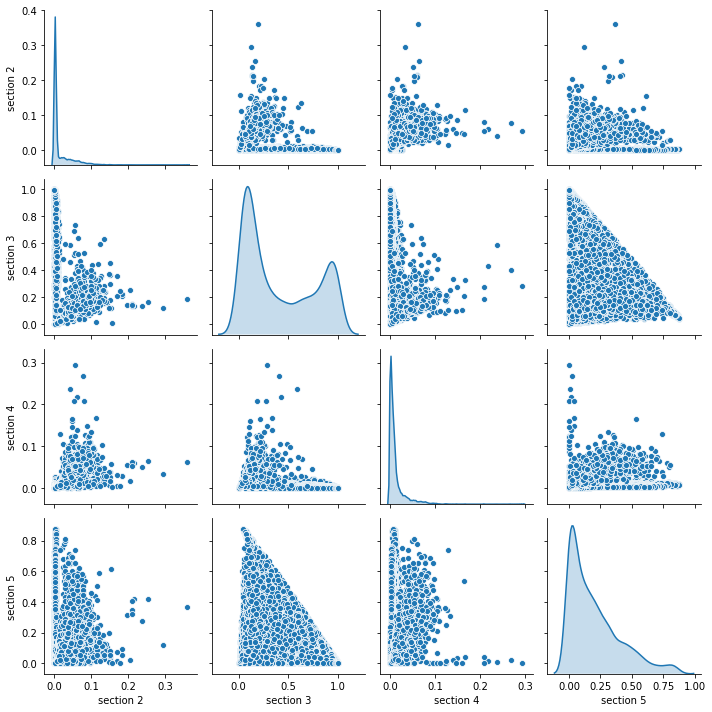

In [118]:
trained_lenet_model = trained_lenet_model.eval()
make_exp_plots_trained(trained_lenet_model, data.reshape(-1,1,28,28), data_name, fig_name, module_name)

##### Eval on random data

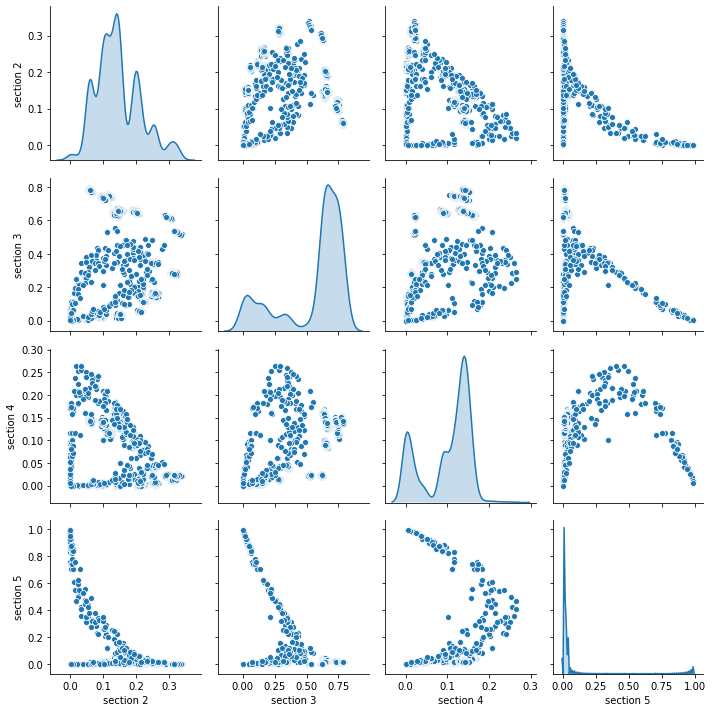

In [119]:
data = random_data
data_name = 'MNIST'
fig_name = 'iid_normal_data_lenet5_MNIST_trained_aggregated_data_ratiohist_%s.pdf'%ACTIVATION_NAME
trained_lenet_model = trained_lenet_model.eval()
make_exp_plots_trained(trained_lenet_model, data.reshape(-1,1,28,28), data_name, fig_name, module_name)

#### Trained MLP5

In [120]:
data = mnist_trainset.data.float()
data_name = 'MNIST'
fig_name = 'MNIST_data_MLP5_trained_aggregated_data_ratiohist_%s.pdf'%ACTIVATION_NAME
module_name = 'MLP5'


Model achieves 97% accuracy.

##### Eval on MNIST

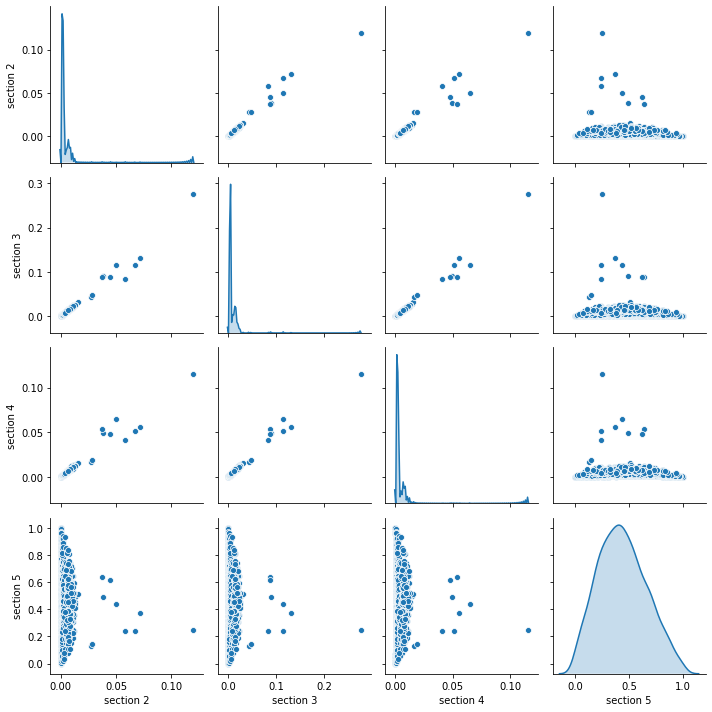

In [121]:
trained_mlp_model = trained_mlp_model.eval()
make_exp_plots_trained(trained_mlp_model, data.reshape(-1,28**2), data_name, fig_name, module_name)

##### Eval on random data

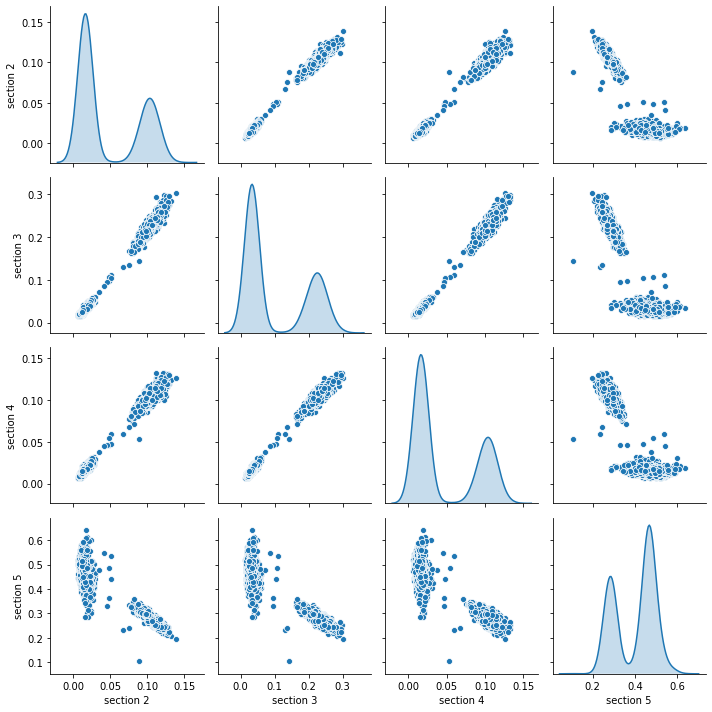

In [122]:
data = random_data
data_name = 'MNIST'
fig_name = 'iid_normal_data_MLP5__MNIST_trained_aggregated_data_ratiohist_%s.pdf'%ACTIVATION_NAME
trained_mlp_model = trained_mlp_model.eval()
make_exp_plots_trained(trained_mlp_model, data.reshape(-1,28**2), data_name, fig_name, module_name)